In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Unbalanced data
from imblearn.combine import SMOTETomek

#Split data
from sklearn.model_selection import train_test_split

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Test confusion matrix
from sklearn.metrics import confusion_matrix

#decision boundary
from pylib.plot import plot_decision_boundary

#tuning parameters
from sklearn.model_selection import RandomizedSearchCV

#subplot
from pylab import *

#warning ignore
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Accuracy
from sklearn.metrics import precision_recall_fscore_support


C:\Users\souad\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
######################################   LOAD DATA:   ################################

df = pd.read_csv('dataset.csv')

df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.info()
print("Dataset size", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest          object
oldBalanceDest    float64
newBalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
Dataset size (6362620, 11)


In [3]:
####################################    DATA PREPROCESSING     ################################
##########################################  CLEAN DATA ########################################

#Relying on EDA, we must to:
#1 deal with umbalanced data
#2 work only with 'TRANSFER's and 'CASH_OUT' transaction
#3 Remove IsFlaggedFraud
#4 Remove Marchand from data
#5 Add new column for amount to deal with missing balnaces 

#print ('dataset size :%s'& df_clean.shape)

# 2 only two types of transactions occurs in fraud,So we assemble only the corresponding data in X for analysis
df_clean = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

# 3 Remove IsFlaggedFraud,it is meaningful because isFraud always set when IsFlaggedFraud is set
df_clean.drop(['isFlaggedFraud'],axis=1,inplace=True)

# fraud occurs only in customers who's name does not start with M
df_clean = df_clean[~df_clean.nameOrig.str.startswith('M') | ~df_clean.nameDest.str.startswith('M')]

# 4 Eliminate columns shown to be irrelevant for analysis in the EDA
df_clean.drop(['nameOrig','nameDest'],axis=1,inplace=True)



print("Dataset size", df_clean.shape)
df_clean.head()

C:\Users\souad\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Dataset size (2770409, 8)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [4]:
####################################    DATA PREPROCESSING     ################################
##################################### Features Engineering ####################################


#5 Add new column for amount to deal with missing balanaces => Features engineering

#There is some descrepancy in the data. oldBalanceSender - amount should equal newBalanceSender
# and oldBalanceReceiver + amount should equal newBalanceReceiver but doesn't always occur. create features
# and remove previous balance from both sender and receiver


df_feature = pd.DataFrame(df_clean)
df_feature['errorBalanceOrig'] = df_feature.oldBalanceOrig + df_feature.amount - df_feature.newBalanceOrig
df_feature['errorBalanceDest'] = df_feature.newBalanceDest + df_feature.amount - df_feature.oldBalanceDest
df_feature['noErrors'] = np.where((df_feature.errorBalanceOrig == 0) & (df_feature.errorBalanceDest == 0), 1, 0)
df_feature.drop(['oldBalanceOrig', 'oldBalanceDest'], 1, inplace=True)
df_feature = df_feature.rename(columns={'newBalanceOrig':'balanceSender', 'newBalanceDest':'balanceReceiver'})


#df_feature.dtypes

#change order of columns
df_feature = df_feature[['type','step', 'amount', 'balanceSender', 'balanceReceiver', 'errorBalanceDest','errorBalanceOrig','noErrors','isFraud']]


print("Dataset size", df_feature.shape)
df_feature.head()

Dataset size (2770409, 9)


,type,step,amount,balanceSender,balanceReceiver,errorBalanceDest,errorBalanceOrig,noErrors,isFraud
2,TRANSFER,1,181.00,0.0,0.00,181.00,362.00,0,1
3,CASH_OUT,1,181.00,0.0,0.00,-21001.00,362.00,0,1
15,CASH_OUT,1,229133.94,0.0,51513.44,275564.38,244458.94,0,0
19,TRANSFER,1,215310.30,0.0,0.00,192885.30,216015.30,0,0
24,TRANSFER,1,311685.89,0.0,2719172.89,3024591.78,322520.89,0,0


In [5]:
####################################    DATA PREPROCESSING     ################################
######################################  DATA Training   ####################################


# --------- Binary-encoding of labelled data in 'type'  TRANSFER = 1, CASH_OUT = 0

#df_feature['type'] = np.where(df_feature['type'] == 'TRANSFER', 1, 0)
#df_feature = df_feature.reset_index(drop=True)

# --------- Binary-encoding of labelled data in 'type'  TRANSFER = 1, CASH_OUT = 0

one_hot = pd.get_dummies(df_feature['type'])
df_feature = df_feature.drop('type',axis = 1)
df_feature = df_feature.join(one_hot)


# ---------- Split data to tarin and target
y_data = df_feature['isFraud']
x_data = df_feature.drop(['isFraud'],axis=1)

# ----------------- - Standardize the data
from sklearn.preprocessing import StandardScaler
x = x_data.values
x_data = StandardScaler().fit_transform(x)

#-------------------Split data to training=60% and test=40%
X_train, X_test, Y_train, Y_test=train_test_split(x_data, y_data, test_size=0.4)
p=100*float(sum(x == 1 for x in Y_train))/Y_train.size
q=100*float(sum(x == 1 for x in Y_test))/Y_test.size
r=100*float(sum(x == 1 for x in y_data))/y_data.size

#
Y_train=mod(Y_train,2)*2-1
Y_test=mod(Y_test,2)*2-1

print("Dataset       : ",y_data.size,'with %.4f'% r,'% fraudulent transactions')
print("Data training : ",Y_train.size,'with %.4f'% p,'% fraudulent transactions')
print("Data test     : ",Y_test.size,'with %.4f'% q,'% fraudulent transactions')

Dataset       :  2770409 with 0.2965 % fraudulent transactions
Data training :  1662245 with 0.2941 % fraudulent transactions
Data test     :  1108164 with 0.3000 % fraudulent transactions


In [6]:
print(sum(x == 1 for x in Y_train))


4889


In [7]:
####################################    DATA PREPROCESSING     ################################
###################################### FEATURES SELECTION ####################################

#----------------- PCA : singular value decomposition SVD ---------------

# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_train, axis=0)
cov_mat = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

# Find the eigenvector beyond which 90% of the data is explained
[ n for n,i in enumerate(cum_var_exp) if i>90 ][0]

#So, we need 4 eigenvectors to explain 90% of the variance. So, let us reshape our training data matrix into a 42000*228 
#matrix with each column corresponding to the projections onto the eigenvectors.

# Call the PCA method with 4 components. 
pca_train = PCA(n_components=4)
pca_test = PCA(n_components=4)

pca_train.fit(X_train)
pca_test.fit(X_test)

X_train = pca_train.transform(X_train)
X_test=pca_train.transform(X_test)

print("Data training size", X_train.shape)
print("Data test size", X_test.shape)


Data training size (1662245, 4)
Data test size (1108164, 4)


After OverUnderSampling, the shape of train_X: (3310896, 4)


Text(0,0.5,'Frequency')

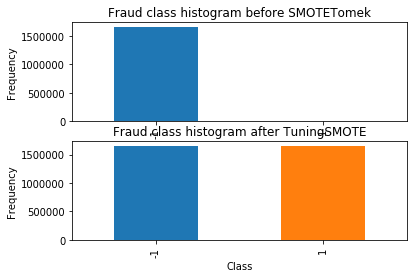

In [8]:
####################################    DATA PREPROCESSING     ################################
###################################### Unbalanced data ########################################


subplot(2,1,1)
pd.value_counts(Y_train).plot.bar()
plt.title('Fraud class histogram before SMOTETomek')
plt.xlabel('Class')
plt.ylabel('Frequency')

#---------------------- OverSampling and UnderSampling

smt = SMOTETomek(ratio='auto')
x_train, y_train = smt.fit_sample(X_train, Y_train.ravel())


print('After OverUnderSampling, the shape of train_X: {}'.format(x_train.shape))

subplot(2,1,2)
pd.value_counts(y_train).plot.bar()
plt.title('Fraud class histogram after TuningSMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')


In [9]:
X_tun, x, Y_tun,y=train_test_split(X_train, Y_train, test_size=0.95)
X_tun.shape

(83112, 4)

In [10]:
#####################################   Building Models   #############################
############################# Parameter tuning for Random Forest ######################

#Sub sample our dataset 
#Use the obtained fraction to tune the hyperparameters on
X_tun, x, Y_tun,y=train_test_split(X_train, Y_train, test_size=0.95)
X_tun.shape

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 10, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
start_time = time.time()
rf_random.fit(X_tun[:10,:], Y_tun[:10])
print("--- Model Fitting in %s seconds ---" % (time.time() - start_time))

#view the best parameters from fitting the random search
best_random=rf_random.best_params_


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


--- Model Fitting in 82.37213563919067 seconds ---


In [21]:
best_random=rf_random.best_params_


In [26]:
from sklearn.metrics import accuracy_score

def evaluate(model, x_test, y_true):
    y_pred = model.predict(x_test)
    print('Model Performance :')
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1_score)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return f1_score
'''
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, Y_train)
'''
base_F1 = evaluate(base_model, X_train, Y_train)


random_F1 = evaluate(rf_random., X_train, Y_train)

print('Improvement of {:0.2f}%.'.format( 100 * (base_F1 - random_F1) / base_F1))

Model Performance :
Precision:  0.9995231282784931
Recall:  0.8574350582941297
F1 score:  0.9230430474512826
Accuracy = 1.00%.


AttributeError: 'dict' object has no attribute 'predict'

In [25]:
####################################    BUILDING MODEL     ################################
######################################  Functions ######################################

import itertools

def drawConfusionMatrix(cm, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix of Transactions')
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    fig.colorbar(cax)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def correctFraudCount(y, y_pred):
    labels = ['Not Fraud', 'Fraud']
    cm = confusion_matrix(y, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred, average='binary')
    
    print ('\n Precision : {:.3f}%'.format(precision))     
    print (' Sensitive : {:.3f}%'.format(recall))
    print (' F1 measure : {:.3f}'.format(f1_score))

    drawConfusionMatrix(cm, labels)
    
    
def printModel(model, testX, testY, y_pred):
    #print('Percent Accuracy: {:.3f}%'.format(model.score(testX, testY)*100))
    correctFraudCount(testY, y_pred)
    

def runModel(name, model, trainX, trainY, testX, testY):
    print('=' * 20, name, '=' * 20)
    start_time = time.time()
    model.fit(trainX, trainY)
    print("--- Model Fitting in %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    y_pred = model.predict(testX)
    print("--- Model Predicting in %s seconds ---" % (time.time() - start_time))
    plot_decision_boundary(model, X=trainX, Y=trainY)
    printModel(model, testX, testY, y_pred)
    
  

In [18]:
################################ Train and Test Models #############################
#################################    Unbalanced Data   #############################

#Create Models: Tuning RF and DT 
#Run Models on Umbalanced data

#n_estimators=1000,max_features='sqrt': max_features,max_depth=110,min_samples_split=2,min_samples_leaf=1,bootstrap=True
'''   
#create Random forest
rf=hyperparameters('RF',X_train, Y_train,0.9)
Evaluationhyperparameters('RF',rf.best_params_,X_train, Y_train)
RF_model=rf.best_estimator_

#Create desicion tree
dt=hyperparameters('DT',X_train, Y_train,0.9)
Evaluationhyperparameters('DT',dt.best_params_,X_train, Y_train)
DT_model=rf.best_estimator_
'''
#DT_model = RandomForestClassifier(n_estimators=1000,max_features='sqrt',max_depth=110,min_samples_split=2,min_samples_leaf=1,bootstrap=True)
DT_model = RandomForestClassifier(n_estimators=200,max_features='sqrt',max_depth=50,min_samples_split=10,min_samples_leaf=2,bootstrap=True)
#RF_model = DecisionTreeClassifier(max_features='sqrt',max_depth=110,min_samples_split=2,min_samples_leaf=1)
    
#run models
runModel('Random Forest', RF_model, X_train, Y_train, X_test, Y_test)
runModel('Decision tree', DT_model, X_train, Y_train, X_test, Y_test)



NameError: name 'runModel' is not defined

==================== Random Forest ====================
--- Model Fitting in 33.705031871795654 seconds ---
--- Model Predicting in 0.1849052906036377 seconds ---

 Precision : 0.950%
 Sensitive : 0.875%
 F measure : 1.414%
 ROC : 0.954%


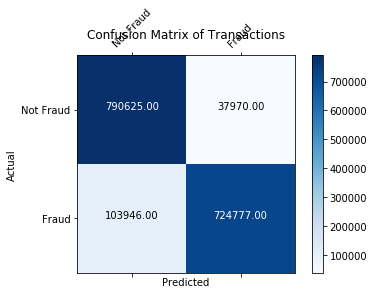

==================== Decision tree ====================
--- Model Fitting in 156.74718594551086 seconds ---
--- Model Predicting in 2.083489418029785 seconds ---

 Precision : 0.958%
 Sensitive : 0.871%
 F measure : 1.414%
 ROC : 0.962%


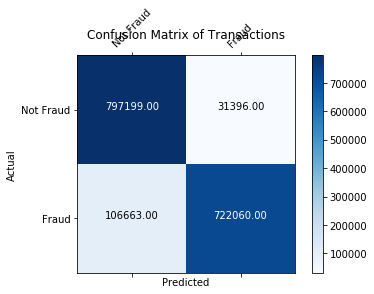

(<Figure size 432x432 with 1 Axes>,
 StandardScaler(copy=True, with_mean=True, with_std=True),
 PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False))

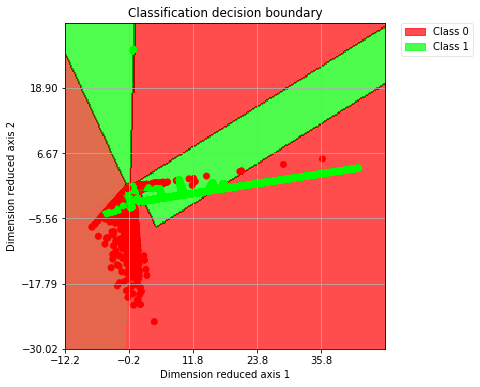

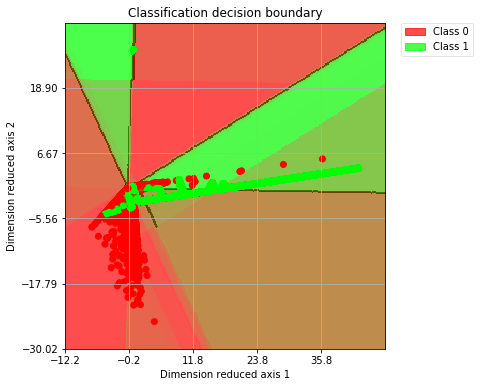

In [167]:
################################ Train and Test Models #############################
#################################    SMOTETOMEK Data   #############################
#Create Models: Tuning RF and DT 
#Run Models on Umbalanced data



#create Random forest
rf=hyperparameters('RF',x_train, y_train,0.9)
Evaluationhyperparameters('RF',rf.best_params_,x_train, y_train)
RF_model=rf.best_estimator_

#Create desicion tree
dt=hyperparameters('DT',x_train, y_train,0.9)
Evaluationhyperparameters('DT',dt.best_params_,x_train, y_train)
DT_model=rf.best_estimator_

#run models
runModel('Random Forest', RF_model, x_train, y_train, X_test, Y_test)
runModel('Decision tree', DT_model, x_train, y_train, X_test, Y_test)



In [ ]:
################################ Train and Test Models #############################
#################################    Cost sensitive   #############################

#create Random forest
rf=hyperparameters('RF',X_train, Y_train,0.9,class_weight={0:1,1:2})
Evaluationhyperparameters('RF',rf.best_params_,X_train, Y_train)
RF_model=rf.best_estimator_

#Create desicion tree
dt=hyperparameters('DT',X_train, Y_train,0.9,class_weight={0:1,1:2})
Evaluationhyperparameters('DT',dt.best_params_,X_train, Y_train)
DT_model=rf.best_estimator_

#run models
runModel('Random Forest', RF_model, X_train, Y_train, X_test, Y_test)
runModel('Decision tree', DT_model, X_train, Y_train, X_test, Y_test)
